# ML with Medicare data

# Jupyter + EC2

Recommended minimum instance type: r4.2xlarge.

See this script for launching the instance and notebook: https://github.com/rikturr/aws-ml-experimenter/blob/master/experiments/jupyter.py

Information about dataset: https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Medicare-Physician-and-Other-Supplier-PUF-Methodology.pdf

### latest version of pandas causing issues with size of DataFrame
* use 0.21 for now
* issue: https://github.com/pandas-dev/pandas/issues/26314

In [1]:
!pip install pandas==0.21

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse as sp
%matplotlib inline

# Download Data

Be nice to my wallet and only run this from an EC2 instance!

In [3]:
!aws s3 ls s3://rikturr

                           PRE images/
2018-02-03 16:24:43 2160155698 2015_partB.txt
2018-02-04 15:53:18   14879264 2015_partB_lookup.csv
2018-01-20 21:45:28   11989398 2015_partB_miami.txt
2018-02-04 16:07:46   18450221 2015_partB_sparse.npz
2018-02-08 13:23:24     499792 2015_partD_drug.csv
2018-03-23 18:31:48   23588232 2015_partD_miami.txt
2018-02-08 12:59:44  612943841 2015_physician_compare.csv
2018-02-08 13:09:24    7621880 2015_physician_compare_miami.csv
2019-08-08 20:27:21     494616 images


In [4]:
!aws s3 cp s3://rikturr/2015_partB.txt .

download: s3://rikturr/2015_partB.txt to ./2015_partB.txt          


In [5]:
import pandas as pd
df = pd.read_csv('2015_partB.txt', sep='\t')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Exploratory analysis

In [6]:
df.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
0,1,CPT copyright 2014 American Medical Associatio...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,23.0,23.0,23.0,72.680000,328.000000,54.502609,55.280870
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,18.0,18.0,18.0,135.850000,614.000000,100.958889,102.348889
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99221,"Initial hospital inpatient care, typically 30 ...",N,59.0,58.0,59.0,101.365085,333.288136,79.469661,80.859831
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99222,"Initial hospital inpatient care, typically 50 ...",N,132.0,130.0,132.0,139.010455,356.492424,107.933409,107.969621


In [7]:
df.shape

(9497892, 26)

In [8]:
df.dtypes

npi                                   int64
nppes_provider_last_org_name         object
nppes_provider_first_name            object
nppes_provider_mi                    object
nppes_credentials                    object
nppes_provider_gender                object
nppes_entity_code                    object
nppes_provider_street1               object
nppes_provider_street2               object
nppes_provider_city                  object
nppes_provider_zip                   object
nppes_provider_state                 object
nppes_provider_country               object
provider_type                        object
medicare_participation_indicator     object
place_of_service                     object
hcpcs_code                           object
hcpcs_description                    object
hcpcs_drug_indicator                 object
line_srvc_cnt                       float64
bene_unique_cnt                     float64
bene_day_srvc_cnt                   float64
average_Medicare_allowed_amt    

In [9]:
df[['npi', 'provider_type', 'place_of_service', 'hcpcs_code', 'hcpcs_description', 'line_srvc_cnt']]

,npi,provider_type,place_of_service,hcpcs_code,hcpcs_description,line_srvc_cnt
0,1,NaN,NaN,NaN,NaN,NaN
1,1003000126,Internal Medicine,F,99217,Hospital observation care discharge,23.0
2,1003000126,Internal Medicine,F,99219,Hospital observation care typically 50 minutes,18.0
3,1003000126,Internal Medicine,F,99221,"Initial hospital inpatient care, typically 30 ...",59.0
4,1003000126,Internal Medicine,F,99222,"Initial hospital inpatient care, typically 50 ...",132.0
5,1003000126,Internal Medicine,F,99223,"Initial hospital inpatient care, typically 70 ...",220.0
6,1003000126,Internal Medicine,F,99231,"Subsequent hospital inpatient care, typically ...",38.0
7,1003000126,Internal Medicine,F,99232,"Subsequent hospital inpatient care, typically ...",1117.0
8,1003000126,Internal Medicine,F,99233,"Subsequent hospital inpatient care, typically ...",580.0
9,1003000126,Internal Medicine,F,99238,"Hospital discharge day management, 30 minutes ...",175.0


In [10]:
provider_types = df['provider_type'].value_counts().reset_index()
provider_types

,index,provider_type
0,Diagnostic Radiology,1222851
1,Internal Medicine,1170216
2,Family Practice,972638
3,Cardiology,458508
4,Nurse Practitioner,418189
5,Orthopedic Surgery,309610
6,Physician Assistant,306141
7,Ophthalmology,240288
8,Anesthesiology,227378
9,Emergency Medicine,225408


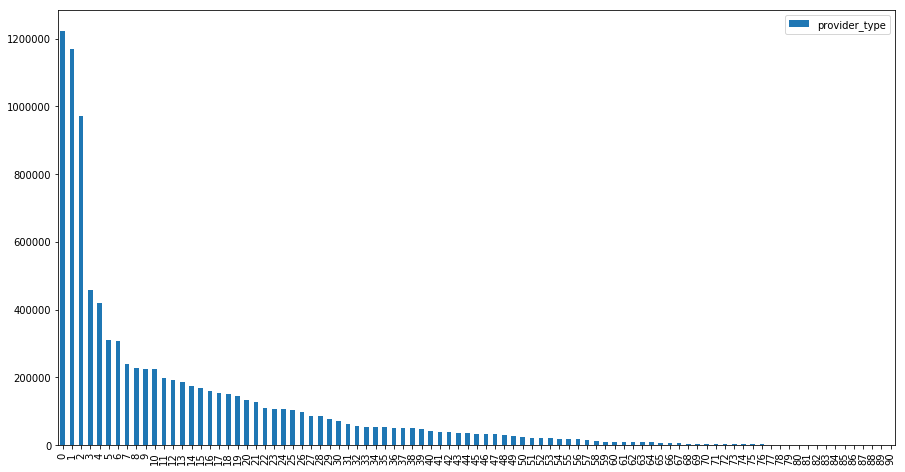

In [11]:
provider_types.plot(kind='bar', figsize=(15, 8))

# Create dataset for modeling

### take top 10 specialty types

* save as scipy sparse matrix

In [12]:
top_type = provider_types[provider_types.index <= 10]
top_type

,index,provider_type
0,Diagnostic Radiology,1222851
1,Internal Medicine,1170216
2,Family Practice,972638
3,Cardiology,458508
4,Nurse Practitioner,418189
5,Orthopedic Surgery,309610
6,Physician Assistant,306141
7,Ophthalmology,240288
8,Anesthesiology,227378
9,Emergency Medicine,225408


In [13]:
top10 = df[df['provider_type'].isin(top_type['index'])]
top10.shape

(5774810, 26)

### collapse place of service

In [14]:
num_hcpcs = top10.groupby(['npi', 'hcpcs_code'])['place_of_service'].nunique()
num_hcpcs[num_hcpcs > 1]

npi         hcpcs_code
1003000522  99214         2
1003000936  93306         2
1003002783  74000         2
1003006107  93306         2
            93970         2
            99213         2
1003007170  93306         2
1003007204  78452         2
            93018         2
            93306         2
            93880         2
            99202         2
1003007980  78452         2
            93018         2
            93306         2
1003009861  78452         2
            93306         2
            99204         2
            99214         2
1003011933  71020         2
            71101         2
            72050         2
            72072         2
            72100         2
            72110         2
            73030         2
            73130         2
            73560         2
            73610         2
            73630         2
                         ..
1992983746  77052         2
            G0202         2
1992987770  93306         2
1992989081  99304        

In [15]:
clean = (top10
         .groupby(['npi', 'provider_type', 'hcpcs_code'])['line_srvc_cnt'].sum()
         .reset_index())

In [16]:
clean.head()

,npi,provider_type,hcpcs_code,line_srvc_cnt
0,1003000126,Internal Medicine,99217,23.0
1,1003000126,Internal Medicine,99219,18.0
2,1003000126,Internal Medicine,99221,59.0
3,1003000126,Internal Medicine,99222,132.0
4,1003000126,Internal Medicine,99223,220.0


In [17]:
clean.shape

(5596950, 4)

### one-hot encoding

In [18]:
one_hot = (clean
           .pivot_table(index=['npi', 'provider_type'], columns='hcpcs_code', values='line_srvc_cnt')
           .reset_index()
           .fillna(0))
one_hot['provider_type'] = one_hot['provider_type'].astype('category')

In [19]:
one_hot.shape

(516476, 4208)

In [20]:
one_hot.head()

hcpcs_code,npi,provider_type,00100,00102,00103,00104,00120,00126,00140,00142,...,Q9963,Q9965,Q9966,Q9967,Q9968,Q9969,Q9977,Q9979,V2632,V2785
0,1003000126,Internal Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1003000142,Anesthesiology,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1003000407,Family Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1003000522,Family Practice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003000530,Internal Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### save to sparse matrix
* create lookup file for class labels

In [21]:
lookup = one_hot[['npi', 'provider_type']]
lookup.head()

hcpcs_code,npi,provider_type
0,1003000126,Internal Medicine
1,1003000142,Anesthesiology
2,1003000407,Family Practice
3,1003000522,Family Practice
4,1003000530,Internal Medicine


In [41]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [31]:
lookup.to_csv('data/2015_partB_lookup.csv', index=False)

### check size of matrix
there are a lot of zero's!

In [23]:
one_hot_matrix_df = one_hot.drop(['npi', 'provider_type'], axis=1)
one_hot_matrix = one_hot_matrix_df.values
'Size of matrix: {} GB'.format(one_hot_matrix.nbytes / 1024 / 1024 / 1024)

'Size of matrix: 16.18488174676895 GB'

In [42]:
one_hot_matrix.shape

(516476, 4206)

In [43]:
one_hot_matrix.shape[0] * one_hot_matrix.shape[1]

2172298056

In [25]:
sparse = sp.csc_matrix(one_hot_matrix)
sparse

<516476x4206 sparse matrix of type '<class 'numpy.float64'>'
	with 5596950 stored elements in Compressed Sparse Column format>

In [45]:
5596950 / 2172298056.

0.0025765110752370896

In [46]:
sp.save_npz('data/2015_partB_sparse.npz', sparse)

In [47]:
!ls -lh data

total 32M
-rw-rw-r-- 1 ec2-user ec2-user 15M Dec 18 19:04 2015_partB_lookup.csv
-rw-rw-r-- 1 ec2-user ec2-user 18M Dec 18 19:07 2015_partB_sparse.npz


# Save files to S3

Download notebook also

In [27]:
!aws s3 cp data/2015_partB_sparse.npz <DEST>
!aws s3 cp data/2015_partB_lookup.csv <DEST>

/bin/sh: -c: line 0: syntax error near unexpected token `newline'
/bin/sh: -c: line 0: `aws s3 cp 2015_partB_sparse.npz <DEST>'
/bin/sh: -c: line 0: syntax error near unexpected token `newline'
/bin/sh: -c: line 0: `aws s3 cp 2015_partB_lookup.csv <DEST>'
